In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random
from weight_save import WeightSaver


use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator = nengo_ocl.Simulator
else:
    simulator = nengo.Simulator
    
import sys, os
import math
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display


# Experimental procedure

In [2]:
class Trial():
    def __init__(self, operation, stimulus):
        self.operation = operation
        self.stimulus = stimulus

class Experiment():
    def __init__(self, trial_length, number_of_learning_trials, trials):
        self.trial_length = trial_length
        self.number_of_learning_trials = number_of_learning_trials
        self.trials = trials

    def __call__(self, t):
        t = round(t,4) - .001 # Avoid float problems
        trial_number = math.floor(t / self.trial_length)
        t_in_trial = t - trial_number * self.trial_length
        trial = self.trials[trial_number]
        return trial, t_in_trial

    
    def RETINA_input(self, t):
        trial, t_in_trial = self(t)
        
        if 1 < t_in_trial:# < 1.029:
            return trial.stimulus
        else:
            return "0"

    def G_input(self, t):
        trial = self(t)[0]
        return trial.operation

    def CORRECT_PRIM_input(self, t):
        trial, t_in_trial = self(t)

        # before stimulus appears
        if t_in_trial < 1:
            return 'FOCUS'

        else: # ['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB']
            if trial.operation == 'SIMPLE':
                if   1 < t_in_trial < 1.33:
                    return 'V_COM'
                elif 1.33 < t_in_trial < 1.66:
                    return 'COM_PM'
                else:
                    return '0'

            elif trial.operation == 'CHAINED_ADD':
                if   1 < t_in_trial < 1.33:
                    return 'V_ADD'
                elif 1.33 < t_in_trial < 1.66:
                    return 'ADD_COM'
                elif 1.66 < t_in_trial < 1.99:
                    return 'COM_PM'
                else:
                    return '0'

            elif trial.operation == 'CHAINED_SUB':
                if   1 < t_in_trial < 1.33:
                    return 'V_SUB'
                elif 1.33 < t_in_trial < 1.66:
                    return 'SUB_COM'
                elif 1.66 < t_in_trial < 1.99:
                    return 'COM_PM'
                return '0'

            else:
                print("unknown operation")

    def learning_inhibit_input(self, t):
        trial_number = math.floor(t / self.trial_length)
        if trial_number < self.number_of_learning_trials:
            return 0
        else:
            return -1
        
class RandomExperiment(Experiment):
    def __init__(self, trial_length, n_blocks_per_operation=10, n_trials_per_digit=5, n_different_digits=3, n_different_operations=4):
        trials = []
        for operation in ['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'][:n_different_operations]:
            for i in range(n_blocks_per_operation*n_trials_per_digit):
                for stimulus in ['TWO', 'FOUR', 'SIX', 'EIGHT'][:n_different_digits]:
                    trials.append(Trial(operation, stimulus))
        shuffle(trials)

        super().__init__(trial_length, number_of_learning_trials, trials)

class Button():
    def __init__(self, SP_vectors, trial_length, dt=None, thr=.5, focus_length=1):
        self.t_last_evt = -100
        self.SP_vectors = SP_vectors
        self.t_last_step = 0
        self.dt = dt
        self.thr = thr
        self.trial_length = trial_length
        self.focus_length = focus_length
    
    def __call__(self,t,x):
        if not self.dt or t-self.dt > self.t_last_step:
            self.t_last_step = t
            if t//self.trial_length > self.t_last_evt//self.trial_length and t > (t//self.trial_length)*self.trial_length + self.focus_length:
                for i in range(len(self.SP_vectors)):
                    similarities = np.dot(self.SP_vectors,x)
                    if np.dot(x,self.SP_vectors[i]) > self.thr:
                        self.t_last_evt = t
                        return i+1
                        
        return 0

# Model variables

In [3]:
seed = 1
np.random.seed(seed)
random.seed(seed)
s = spa.sym
D = 32  # the dimensionality of the vectors
AM_THR = .15
ROUTING_THR = .15
GW_threshold = 0

# Number of neurons (per dimension or ensemble)
scale_npds = 1
npd_AM = int(50*scale_npds) # Default: 50
npd_state = int(50*scale_npds) # Default: 50
npd_BG = int(100*scale_npds) # Default: 100
npd_thal1 = int(50*scale_npds) # Default: 50
npd_thal2 = int(40*scale_npds) # Default: 40
n_scalar = int(50*scale_npds) # Default: 50

save_weights = True
load_weights = True

n_blocks_per_operation = 11 # default: 10
n_trials_per_digit = 5 # default: 5
n_different_digits = 4 # default: 4
n_different_operations = 3 # default: 3

number_of_total_trials = n_blocks_per_operation * n_trials_per_digit * n_different_digits * n_different_operations
number_of_non_learning_trials = number_of_total_trials-600
number_of_learning_trials = max(0,number_of_total_trials - number_of_non_learning_trials)
print("number_of_learning_trials",number_of_learning_trials) 
print("number_of_non_learning_trials",number_of_non_learning_trials) 
print("number_of_total_trials",number_of_total_trials)


trial_length = 2.029

T = number_of_total_trials * trial_length - .00001# simulations run a bit too long
print('T',T)

symbol_keys = ['TWO','FOUR','SIX','EIGHT','X', \
               'MORE','LESS', \
    'G', 'V', 'COM', 'ADD', 'SUB', 'PREV', 'PM', \
    'SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'
    ]
prim_keys = ['V_COM', 'COM_PM', 'V_ADD', 'V_SUB', 'ADD_COM', 'SUB_COM', 'V_PM', 'FOCUS']
all_keys = symbol_keys + prim_keys
vocab_memory = spa.Vocabulary(dimensions=D, name='all', pointer_gen=np.random.RandomState(seed))
vocab_memory.populate(";".join(all_keys))
prim_vocab = vocab_memory.create_subset(prim_keys)


xp = RandomExperiment(trial_length, n_blocks_per_operation, n_trials_per_digit, n_different_digits, n_different_operations)

number_of_learning_trials 600
number_of_non_learning_trials 60
number_of_total_trials 660
T 1339.13999


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=12, similarity=0.12)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=13, similarity=0.14)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=14, similarity=0.13)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=15, similarity=0.15)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWar

In [4]:
np.random.seed(seed)
random.seed(seed)

model = spa.Network(seed=seed)
with model:
    
    model.config[spa.State].neurons_per_dimension = npd_state
    #model.config[spa.WTAAssocMem].n_neurons = npd_AM # Doesn't work -> set for individual AM
    model.config[spa.Scalar].n_neurons = n_scalar
    model.config[spa.BasalGanglia].n_neurons_per_ensemble = npd_BG
    model.config[spa.Thalamus].neurons_action = npd_thal1
    model.config[spa.Thalamus].neurons_channel_dim = npd_thal1
    model.config[spa.Thalamus].neurons_gate = npd_thal2

    # We start defining the buffer slots in which information can
    # be placed:
    
    # A slot for the goal/task
    G = spa.State(vocab_memory, label='G')
    
    # A slot for the visual input (the digit N). Feedback is used for iconic memory (100-300ms)
    RETINA = spa.WTAAssocMem(
        0.1,
        vocab_memory,
        mapping=['TWO','FOUR','SIX','EIGHT','X'],
        function=lambda x: x>0,
        n_neurons = npd_AM
    )
    nengo.Connection(RETINA.input, RETINA.input, transform=.85, synapse=.005)
    V = spa.State(vocab_memory, label='V')
    nengo.Connection(RETINA.output, V.input, synapse=.055)
    
    # The previously executed PRIM
    PREV = spa.State(vocab_memory, feedback=.95, feedback_synapse=.05, label='PREV')
    
    # A slot for the action (MORE or LESS)
    PM = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='PM')
    with nengo.Network() as ACT_net:
        ACT_net.config[nengo.Ensemble].neuron_type = nengo.Direct()
        ACT = spa.State(vocab_memory, label='ACT direct')

    # An associative memory for the + operation
    ADD_input = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='ADD_input')
    ADD = spa.WTAAssocMem(threshold=AM_THR, 
        input_vocab=vocab_memory, mapping=
        {
            'TWO':'FOUR',
            'FOUR':'SIX',
            'SIX':'EIGHT',
            'EIGHT':'TWO',
        },
        function=lambda x: x>0,
        label='ADD',
        n_neurons = npd_AM
    )
    ADD_input >> ADD.input
    
    # An associative memory for the - operation
    SUB_input = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='SUB_input')
    SUB = spa.WTAAssocMem(threshold=AM_THR, 
        input_vocab=vocab_memory, mapping=
        {
            'TWO':'EIGHT',
            'FOUR':'TWO',
            'SIX':'FOUR',
            'EIGHT':'SIX',
        },
        function=lambda x: x>0,
        label='SUB',
        n_neurons = npd_AM
    )
    SUB_input >> SUB.input
    
    # An associative memory for the "compare to 5" operation
    COM_input = spa.State(vocab_memory, feedback=.8, feedback_synapse=.05, label='COM_input')
    COM = spa.WTAAssocMem(threshold=AM_THR, 
        input_vocab=vocab_memory, mapping=
        {
            'TWO':'LESS',
            'FOUR':'LESS',
            'SIX':'MORE',
            'EIGHT':'MORE',
        },
        function=lambda x: x>0,
        label='COM',
        n_neurons = npd_AM
    )
    COM_input >> COM.input

    # A slot that combines selected information from the processors
    """GW = spa.State(vocab_memory, neurons_per_dimension = 150, label='GW')"""
    GW = spa.State(vocab_memory, neurons_per_dimension = 150, label='GW', represent_cc_identity=False)
    processors = [G, V, PREV, PM, ADD, SUB, COM]
    competition_keys = {
        G: ['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'],
        V: ['TWO','FOUR','SIX','EIGHT','X'],
        PREV: ['V_COM', 'COM_PM', 'V_ADD', 'V_SUB', 'ADD_COM', 'SUB_COM', 'V_PM', 'FOCUS'],
        PM: ['MORE','LESS'],
        ADD: ['TWO','FOUR','SIX','EIGHT'],
        SUB: ['TWO','FOUR','SIX','EIGHT'],
        COM: ['MORE','LESS'],
    }
    for processor in processors:
        source = processor.output
        if GW_threshold:
            proc_threshold = spa.modules.WTAAssocMem(
                GW_threshold,
                vocab_memory,
                mapping=competition_keys[processor],
                function=lambda x: x>0,
                n_neurons = npd_AM
            )
            processor >> proc_threshold.input
            source = proc_threshold.output
            
        nengo.Connection(source, GW.input, 
            transform=vocab_memory.parse(processor.label).get_binding_matrix())

    # The PRIM state will receive the PRIM to be executed based on GW
    PRIM = spa.State(prim_vocab, label='PRIM')
    
    # We will do supervised learned, so this state will hold the correct PRIM to execute
    CORRECT_PRIM = spa.State(prim_vocab, label='correct action')
    
    # This state will be used to calculate the error
    error = spa.State(prim_vocab, label='error')
    PRIM - CORRECT_PRIM >> error
    
    
    # Create learning connection between GW and PRIM
    weightSavers = []
    folder_name = "final_weights"
    for i,ens in enumerate(GW.all_ensembles):
        
        con = nengo.Connection(ens, PRIM.input, function=lambda t: [0]*D,
                               learning_rule_type=nengo.PES(learning_rate=1e-4)) # was 1e-4 and changed to 1e-5
        nengo.Connection(error.output, con.learning_rule)
        ws = WeightSaver(con, folder_name+'/w'+str(i), load=load_weights, sample_every=T)
        weightSavers.append(ws)
    
    # Create the inputs
    with spa.Network(label='inputs'):
        RETINA_input = spa.Transcode(xp.RETINA_input,output_vocab = vocab_memory)
        G_input = spa.Transcode(xp.G_input, output_vocab = vocab_memory)
        CORRECT_PRIM_input = spa.Transcode(xp.CORRECT_PRIM_input, output_vocab = prim_vocab)

    nengo.Connection(RETINA_input.output, RETINA.input, synapse=None)
    G_input >> G
    CORRECT_PRIM_input >> CORRECT_PRIM
    
    
    learning_inhibit = nengo.Node(output = xp.learning_inhibit_input)
    PRIM_inhibit = spa.Scalar(label='PRIMSdone')
    for ens in error.all_ensembles:
        nengo.Connection(learning_inhibit, ens.neurons, transform=np.ones((ens.n_neurons, 1)) * 10, synapse=None)
        nengo.Connection(PRIM_inhibit.output, ens.neurons, transform=np.ones((ens.n_neurons, 1)) , synapse=None)

    # Definition of the actions
    # There are rules that carry out the actions, and rules that check the
    # conditions. If a condition is satisfied, check is set to YES which
    # is a condition for the actions.
    with spa.Network(label='BG-Thalamus') :
        with spa.ActionSelection() as bg_thalamus:
            # Action rules first
            spa.ifmax( spa.dot(PRIM, s.V_COM),
                        V >> COM_input,
                        s.V_COM >> PREV
                     )
            spa.ifmax( spa.dot(PRIM, s.COM_PM),
                        COM.output >> PM,
                        s.COM_PM >> PREV
                     )
            spa.ifmax( spa.dot(PRIM, s.V_ADD),
                        V >> ADD_input,
                        s.V_ADD >> PREV
                     )
            spa.ifmax( spa.dot(PRIM, s.V_SUB),
                        V >> SUB_input,
                        s.V_SUB >> PREV
                     )
            spa.ifmax( spa.dot(PRIM, s.ADD_COM),
                        ADD.output >> COM_input,
                        s.ADD_COM >> PREV
                     )
            spa.ifmax( spa.dot(PRIM, s.SUB_COM),
                        SUB.output >> COM_input,
                        s.SUB_COM >> PREV
                     )
            spa.ifmax( spa.dot(PRIM, s.FOCUS),
                        s.FOCUS >> PREV
                     )
            spa.ifmax(ROUTING_THR) # Threshold for action
    
    
    with spa.Network(label='Inhibit- BG-Thalamus'):
        with spa.ActionSelection():            
            spa.ifmax( spa.dot(CORRECT_PRIM, s.V_COM) * spa.dot(V,COM),
                        -1.0 >> PRIM_inhibit)
            spa.ifmax( spa.dot(CORRECT_PRIM, s.COM_PM) * spa.dot(COM, PM),
                        -1.0 >> PRIM_inhibit)
            spa.ifmax( spa.dot(CORRECT_PRIM, s.V_ADD) * spa.dot(V,ADD),
                        -1.0 >> PRIM_inhibit)
            spa.ifmax( spa.dot(CORRECT_PRIM, s.V_SUB) * spa.dot(V,SUB),
                        -1.0 >> PRIM_inhibit)
            spa.ifmax( spa.dot(CORRECT_PRIM, s.ADD_COM) * spa.dot(ADD,COM),
                        -1.0 >> PRIM_inhibit)
            spa.ifmax( spa.dot(CORRECT_PRIM, s.SUB_COM) * spa.dot(SUB,COM),
                        -1.0 >> PRIM_inhibit)
            
            spa.ifmax(ROUTING_THR, 0.0 >> PRIM_inhibit)
         
    with spa.Network(label='Action'):
        with spa.ActionSelection():            
                spa.ifmax( spa.dot(PM, s.MORE),
                            s.MORE >> ACT)
                spa.ifmax( spa.dot(PM, s.LESS),
                            s.LESS >> ACT)

                spa.ifmax( AM_THR)
            
    BTN = nengo.Node(Button([vocab_memory.parse('MORE').v, vocab_memory.parse('LESS').v], trial_length), size_in=D)
    nengo.Connection(ACT.output, BTN)

Loading weights from file
Loading weights from file


# Set up some probes

In [5]:
with model:
    
    probe_dt = .05
    #p_V = nengo.Probe(V.output, synapse = 0.01)#, sample_every = probe_dt)
    #p_G = nengo.Probe(G.output, synapse = 0.01)#, sample_every = probe_dt)

    p_PRIM = nengo.Probe(PRIM.output, synapse = 0.01)#, sample_every = probe_dt)
    #p_PREV = nengo.Probe(PREV.output, synapse = 0.01)#, sample_every = probe_dt)

    p_ADD = nengo.Probe(ADD.output, synapse = 0.01)#, sample_every = probe_dt)
    p_SUB = nengo.Probe(SUB.output, synapse = 0.01)#, sample_every = probe_dt)
    p_COM = nengo.Probe(COM.output, synapse = 0.01)#, sample_every = probe_dt)
    
    #p_PM = nengo.Probe(PM.output, synapse = 0.01)#, sample_every = probe_dt)
    p_ACT = nengo.Probe(ACT.output, synapse = 0.01)#, sample_every = probe_dt)
    p_BTN = nengo.Probe(BTN)#, sample_every = probe_dt)
    
    
    print(model.n_neurons)
    

82640


# Run the model

In [6]:
dt = .001
with simulator(model, dt = dt, seed=seed) as sim:
    sim.run(T)
    
if save_weights:
    for ws in weightSavers:
        ws.save(sim)

No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


/home/ubuntu/Documents/Radboud/ERP/code/operations/weight_save.py:32: UserWarning: Weights file does not exist, initializing connection.
  "Weights file does not exist, initializing connection."


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Saving weights to file
(1, 32, 2400)
Saving weights to file
(1, 32, 2400)


# Plot results

In [7]:
if False:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=True, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -1.2, 1.2
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(True)
        plt.plot(t_range, spa.similarity(data, vectors[sort_idx]))
        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Similarity")
        plt.xlim(left=t_range[0], right=t_range[-1])
        plt.xticks(np.arange(t_range[0], t_range[-1], trial_length))
        leg = plt.legend([str(round(mean_activation[sort_idx][i],2))+' '+k for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center',
                   bbox_to_anchor=(0.5, -0.13), ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()

        return subplot_i + 1



    subplot_nrows=10
    subplot_ncols=1
    plt.figure(figsize=(6*subplot_ncols,4.5*subplot_nrows))
    
    start = 0#(number_of_total_trials-10)*trial_length
    end = T
    skip = 5
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT'], title='p_V', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    #subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT'], title='p_V', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_G][selected_idx][::skip], vocab_memory, keys=['SIMPLE','CHAINED_SUB','CHAINED_ADD'], title='p_G', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PRIM][selected_idx][::skip], prim_vocab, title='p_PRIM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PREV][selected_idx][::skip], prim_vocab, title='p_PREV', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT'], title='p_ADD', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB][selected_idx][::skip], vocab_memory, keys=['TWO','FOUR','SIX','EIGHT'], title='p_SUB', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM][selected_idx][::skip], vocab_memory, keys=['MORE','LESS'], title='p_COM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PM][selected_idx][::skip], vocab_memory, keys=['MORE','LESS'], title='p_PM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ACT][selected_idx][::skip], vocab_memory, keys=['MORE','LESS'], title='p_ACT', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)

    trange = sim.trange()[selected_idx]
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.plot(trange, sim.data[p_BTN][selected_idx])
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(np.arange(trange[0], trange[-1], trial_length))
    plt.ylabel("Action")
    plt.grid(True)
    
    plt.tight_layout()

    plt.show()


NameError: name 'p_V' is not defined

<Figure size 432x3240 with 0 Axes>

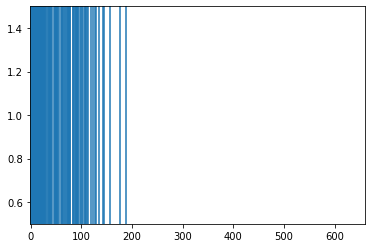

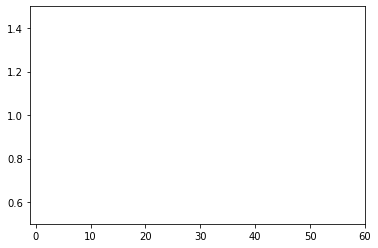

Total score: 568/660
Score after learning: 60/60


In [11]:
key_to_int = {'TWO':2, 'FOUR':4, 'SIX':6, 'EIGHT':8}
COMresult_to_action = {True:'MORE', False:'LESS'}

def get_expected_action(trial):
    N = key_to_int[trial.stimulus] 
    #print(trial.operation, trial.stimulus)
    if trial.operation == 'CHAINED_ADD':
        N += 2
    elif trial.operation == 'CHAINED_SUB':
        N -= 2
    if N > 8:
        N = 2
    elif N < 2:
        N = 8
    expected_action = 1 + int(not N > 5)
    return expected_action

correct = []

t = 0
while t<T-.01:
    
    # Find the expected action
    t += trial_length
    expected_action = get_expected_action(xp(t)[0])
    action_idx = (np.where(np.logical_and(sim.trange() < t, sim.trange() > t-trial_length))[0],)
    model_action = sim.data[p_BTN][action_idx]
    if np.count_nonzero(model_action) > 1:
        print("ERROR: more than one action")
    model_action = model_action.sum()
    correct += [model_action==expected_action]



correct = np.array(correct, dtype=bool)
test_correct = correct[-number_of_non_learning_trials:]

plt.eventplot(np.where(np.logical_not(correct)))
plt.ylim(0.5,1.5)
plt.xlim(-1,len(correct))
plt.show()

plt.eventplot(np.where(np.logical_not(test_correct)))
plt.ylim(0.5,1.5)
plt.xlim(-1,len(test_correct))
plt.show()


print('Total score: '+str(correct.sum())+'/'+str(number_of_total_trials))
print('Score after learning: '+str(test_correct.sum())+'/'+str(number_of_non_learning_trials))
